Step 1: Map the problem to circuits and operators

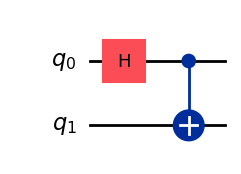

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')


** This is a Bell state **

In [7]:
from qiskit.quantum_info import Pauli
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')
observables = [ZZ, ZI, IZ, XX, XI, IX]

Step 2: Optimise!

Step 3: Execute on the backend

In [8]:

from qiskit_aer.primitives import Estimator

estimator = Estimator()
job = estimator.run([qc] * len(observables), observables)
job.result()



EstimatorResult(values=array([ 1.        , -0.00976562, -0.00976562,  1.        , -0.02734375,
       -0.02734375]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000273708, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.002599, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 8192, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999046325683594, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000273708, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1

Step 4: Post-Process (and plotting)

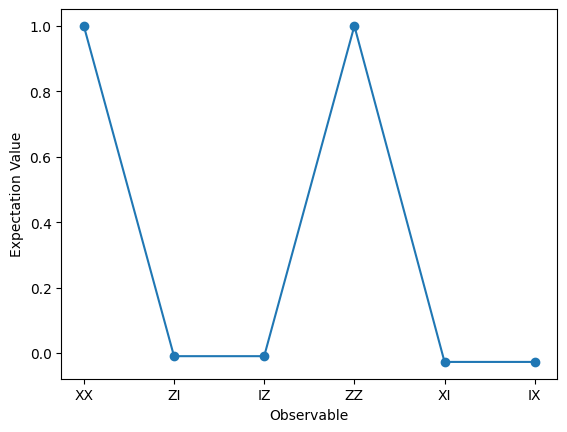

In [9]:
import matplotlib.pyplot as plt
data = ['XX', 'ZI', 'IZ', 'ZZ', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observable')
plt.ylabel('Expectation Value')
plt.show()

PART II: Extend the Hello World example to an n-qubit GHZ gate

Step 1: Map the problem to circuits and operators

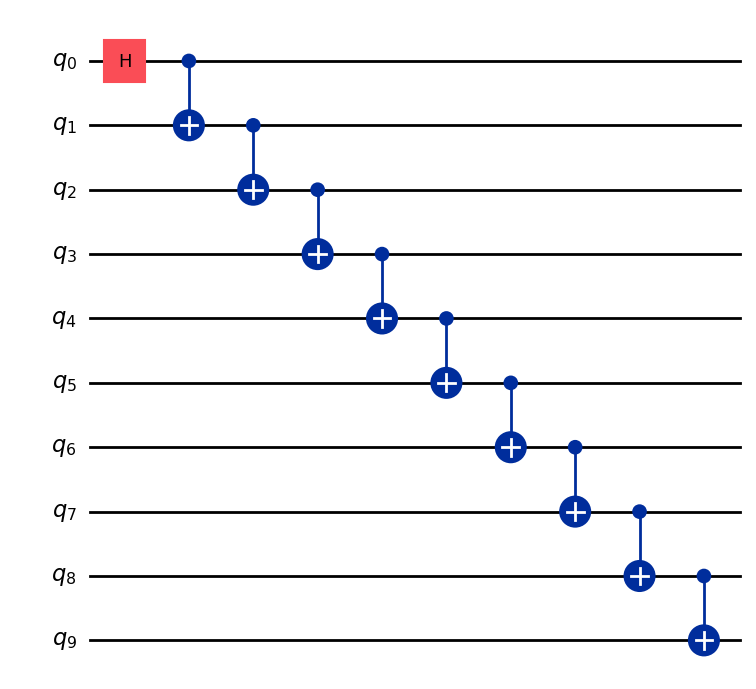

In [10]:
def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i , i+1)
    return qc
n = 10
gc = get_qc_for_n_qubit_GHZ_state(n)
gc.draw(output='mpl')

In [11]:
from qiskit.quantum_info import SparsePauliOp
operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_strings) for operator_strings in operator_strings]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


Step 2: Optimise the problem for quantum execution

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend_name = "ibm_brisbane" # the IBM Quantum service that we want to use
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
qc_transpiled = pm.run(gc)
operator_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

Step 3: Execute on the Backend

In [13]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()


estimator = Estimator( backend,options=options)
job = estimator.run([(qc_transpiled, operator_transpiled_list)])
job_id = job.job_id()
print(job_id)


# You can see your work's id on your https://quantum.ibm.com/ dashboard

cxgwk1c6t010008cr8p0


Step 4: Post-Process and plot

In [14]:
job_id ='cxgwbcd6t010008cr7yg'
job = service.job(job_id)

In [15]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()

KeyboardInterrupt: 